# This notebook implements the routine for low SNR edge fitting

        What it should be done:
            - load source spectrum
            - load material attenuation spectrum
            - apply poisson noise according to flux, pixels, exposure time
            - provide different fitting methods:
                - S-G filter: smoothing of 1D signal
                - 3D moving average convolution
                - fit with weights by covariance found in space domain
            - return metrics for assessing quality:
                - RMSE

In [21]:
import math 
import h5py 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy.io
import scipy.signal
import pylab as pl
%matplotlib inline  
#%matplotlib notebook

import sys
sys.path.append('C:\\Users\\busi_m\\Workspace\\neutronimaging\\ToFImaging')
from lib import srcs
from lib import mats
from lib import signpro
from lib import stats

# Loading spectra

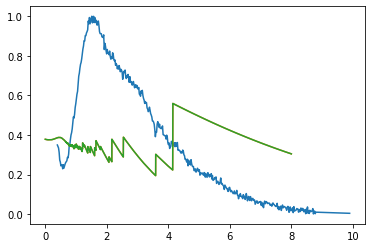

In [2]:
ICON = srcs.ICON_spectrum()
mu = mats.Fe_gamma()



T=mu
T[:,0] = mu[:,0]
T[:,1] = np.exp(-mu[:,1])

plt.plot(ICON[:,0],ICON[:,1])
plt.plot(mu[:,0],mu[:,1])
plt.plot(T[:,0],T[:,1])
plt.show()
plt.close()


# Apply Poisson noise

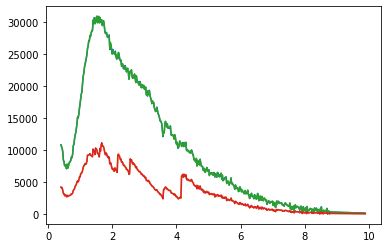

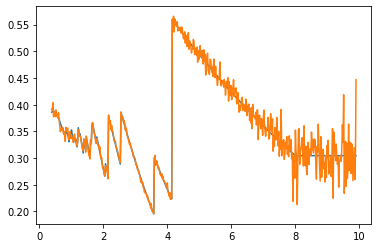

In [3]:
fps = 1.7e8  # source flux n /s/cm^2
exp_t = 60 * 10 * 1  # exposure time ( s * m * h)
pixel_s = 0.0055 * 0.0055
duty = 0.01
flux = fps * exp_t * pixel_s * duty

l = ICON[:,0]
y0 = flux*ICON[:,1]
T_int = np.interp(l, T[:, 0], T[:, 1])
y = y0*T_int
y0_n = np.random.poisson(y0)
y_n = np.random.poisson(y)
T_n = np.divide(y_n,y0_n)

plt.plot(l,y0)
plt.plot(l,y)
plt.plot(l,y0_n)
plt.plot(l,y_n)
plt.show()
plt.close()

plt.plot(l,T_int)
plt.plot(l,T_n)
plt.show()
plt.close()

# Repeat for a flat panel detector (just 128x128 for speed)

In [4]:
size = 128
Y0 = np.tile(y0,(size,size,1))
Y = np.tile(y0*T_int,(size,size,1))

Y0_n = np.random.poisson(Y0)
Y_n = np.random.poisson(Y)
T_n = np.divide(Y_n,Y0_n)


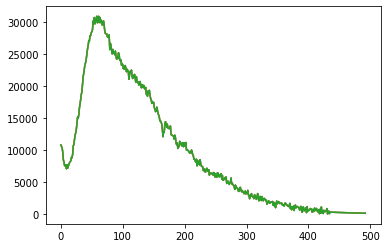

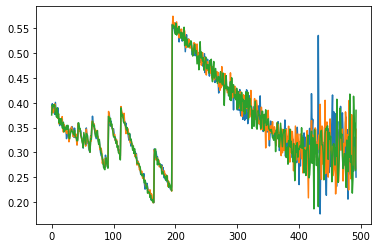

In [5]:
plt.plot(Y0[64,64])
plt.plot(Y0[64,65])
plt.plot(Y0[64,66])
plt.show()
plt.close()

plt.plot(T_n[64,64])
plt.plot(T_n[64,65])
plt.plot(T_n[64,66])
plt.show()
plt.close()


# S-G filter - Savitzky–Golay filter - Standard 1D smoothing 
    Applied pixelwise to each spectrum. Example here is for one pixel.
    Requires two parameters:
        - Filtering window size
        - Polynomial order

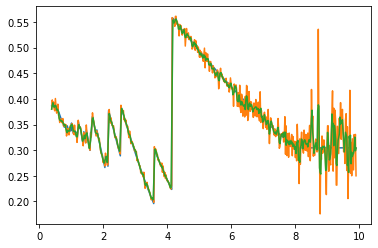

R = 0.024157761804955925
R_corr = 0.016483148711649607
Improvement =  -31.76872574234871 %


In [13]:
window = 3
order = 1 

mu_n = T_n[int(size/2),int(size/2),:]
mu_corr = signpro.savitzky_golay(mu_n,window,order)
R = stats.rmse(mu_n,T_int)
R_corr = stats.rmse(mu_corr,T_int)

plt.plot(l,T_int)
plt.plot(l,mu_n)
plt.plot(l,mu_corr)
plt.show()
plt.close()


print("R =",R)
print("R_corr =",R_corr)
print("Improvement = ",100*(R_corr-R)/R,"%")

# Moving Average - Convolution with a kernel
    In this approach we convolute the ToF frames with a convolution kernel which does the moving average.
    Parameters:
        - Dimension of the convolutional kernel: 1D, 2D, 3D
        - Axis/axes of the kernel if it's 1D/2D
        - Size of the convolutional kernel (along the three axes)
        - Kernel shape:
            - Matrix of ones (arithmetic average)
            - Triangular matrix (give more weight to the central pixel)
        
       

ValueError: x and y must have same first dimension, but have shapes (493,) and (128, 128, 493)

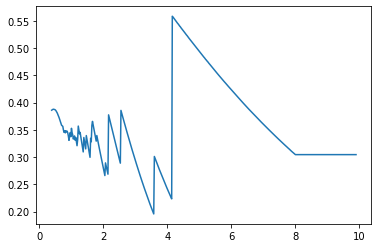

In [27]:
#dim = 2
Ksize = 3
K1 = np.ones((Ksize,Ksize))
Y0_c = np.zeros((int(np.shape(Y0)[0]),int(np.shape(Y0)[1]),int(np.shape(Y0)[2])))
Y_c = np.zeros((int(np.shape(Y0)[0]),int(np.shape(Y0)[1]),int(np.shape(Y0)[2])))
T_c_dir = np.zeros((int(np.shape(Y0)[0]),int(np.shape(Y0)[1]),int(np.shape(Y0)[2])))
for i in range(0,int(np.shape(Y0)[2]),1):
    Y0_c[:,:,i] = scipy.signal.convolve2d(Y0[:,:,i],K1,'same')
    Y_c[:,:,i] = scipy.signal.convolve2d(Y[:,:,i],K1,'same')
    T_c_dir[:,:,i] = scipy.signal.convolve2d(T_n[:,:,i],K1,'same')
T_c = np.divide(Y_c,Y0_c)

plt.plot(l,T_int)
plt.plot(l,T_c)
plt.plot(l,T_c_dir)
plt.show()
plt.close()
